In [14]:
#some basic imports and setups
import os
import cv2
import math
import pandas as pd
import shutil
import glob
from random import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


#mean of imagenet dataset in BGR (?)
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

#Need a folder with test images
current_dir = os.getcwd()

#image testing for business: business_hg, business_bk, business_fmrs
business_name = 'business_bk'
image_dir= os.path.join(current_dir, business_name)

#visulize after loading
num_visualize = 27
num_r = math.ceil(num_visualize/3)

#correctlty classified/missclassified visualize
num_r_gb= 2*num_r


#path to checckpoint
pth_ckpt = 'finetune_alexnet/yelp_ckpts/train_2l_20e/model_epoch20.ckpt'

%matplotlib inline

In [15]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]


#load all images and save the index of ground truth
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
print(len(imgs))

num_visualize = len(imgs) 
num_r = math.ceil(num_visualize/3)

28


In [16]:
from alexnet import AlexNet
from yelp_classes import class_names

tf.reset_default_graph() 

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = AlexNet(x, keep_prob, 2, [])

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

#define activation of last layer as score
score = model.fc8

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

print(class_names)

['poor', 'good', '']


In [17]:
fig2 = plt.figure(figsize=(15,6))

good_prob = []
class_gp  = []

with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    #model.load_initial_weights(sess)
    saver.restore(sess, pth_ckpt)
    
    vis = 0  #counter for number of  visulalized so far

    
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))
        
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        #get higher prob
        good_prob.append(np.max(probs))
        class_gp.append(class_name)

INFO:tensorflow:Restoring parameters from finetune_alexnet/yelp_ckpts/train_2l_20e/model_epoch20.ckpt


<Figure size 1080x432 with 0 Axes>

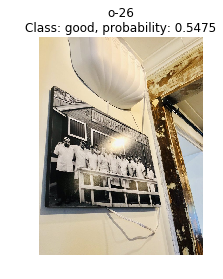

In [18]:
#Plot image with class name and prob in the title
good_prob = np.asarray(good_prob)
good_prob_idx = np.argsort(-1*good_prob)

vis = 0

for idx in good_prob_idx:
    if(vis < num_visualize):
        imgn = os.path.basename(img_files[idx])
        filename, file_extension = os.path.splitext(imgn)
        plt.imshow(cv2.cvtColor(imgs[idx], cv2.COLOR_BGR2RGB))
        plt.title(filename + "\nClass: " + class_gp[idx] + ", probability: %.4f" %good_prob[idx])
        plt.axis('off')
        fig_nm = './results/' + business_name + '/img_' + str(vis) + '.png'
        plt.savefig(fig_nm)
        vis = vis + 1